In [1]:
# 라이브러리 임포트
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# BaseModel 정의
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv1_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        
        self.conv2_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.conv3_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.conv4_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.GAP = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_M(out)
        
        out = self.conv2(out)
        out = self.conv2_M(out)
        
        out = self.conv3(out)
        out = self.conv3_M(out)
        
        out = self.conv4(out)
        out = self.conv4_M(out)
        
        out = self.conv5(out)
        out = self.GAP(out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [2]:
# 데이터 전처리 정의
class PadToSquare(object):
    def __init__(self, padding_value=0):
        self.padding_value = padding_value
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()

    def __call__(self, image):
        image_tensor = self.to_tensor(image)
        _, height, width = image_tensor.shape
        max_size = max(height, width)
        padding = (0, 0, max_size - width, max_size - height)
        return self.to_pil(F.pad(image_tensor, padding, value=self.padding_value))

# 데이터 경로
train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/train'
test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/test'

# 데이터 전처리 및 로더 정의
transform = transforms.Compose([
    PadToSquare(),
    transforms.Resize((228, 228)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Number of training samples: 1000
Number of test samples: 100
Classes: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'football', 'golf_ball', 'shuttlecock', 'tennis_ball', 'volleyball']


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = BaseModel().to(device)
encoder.load_state_dict(torch.load('/home/gidaseul/Documents/GitHub/ML_2/sportsball/sportsball_weights.pth'))
encoder.eval()
print("Pre-trained weights loaded successfully.")


Pre-trained weights loaded successfully.


/tmp/ipykernel_19145/2648081276.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('/home/gidaseul/Documents/GitHub/ML_2/sportsball/sport

In [4]:
def extract_latent_features(model, images):
    out = model.conv1(images)
    out = model.conv1_M(out)
    out = model.conv2(out)
    out = model.conv2_M(out)
    out = model.conv3(out)
    out = model.conv3_M(out)
    out = model.conv4(out)
    out = model.conv4_M(out)
    out = model.conv5(out)
    out = model.GAP(out)
    latent_features = out.view(out.size(0), -1)
    return latent_features


In [5]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

classifier = Classifier(input_dim=512, num_classes=10).to(device)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        features = F.normalize(features, dim=1)
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float().to(features.device)
        sim_matrix = torch.matmul(features, features.T) / self.temperature
        logits = sim_matrix - torch.eye(features.size(0)).to(features.device) * 1e12
        exp_logits = torch.exp(logits)
        positive_logits = torch.sum(exp_logits * mask, dim=1)
        total_logits = torch.sum(exp_logits, dim=1)
        loss = -torch.log(positive_logits / total_logits).mean()
        return loss

criterion_contrastive = SupConLoss()
criterion_classifier = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)


In [ ]:
# 학습 및 검증 루프
num_epochs = 50
best_test_loss = float('inf')  # 최적의 Test Loss를 저장
patience_counter = 0  # Early Stopping용 카운터 초기화
early_stopping_patience = 10  # Test Loss가 개선되지 않을 경우 몇 번의 Epoch 동안 대기할지 설정

for epoch in range(num_epochs):
    # === Train Phase ===
    classifier.train()  # Train 모드 활성화 (Dropout 및 BatchNorm 활성화)
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        # 데이터를 GPU/CPU로 전송
        images, labels = images.to(device), labels.to(device)

        # Encoder에서 Latent Feature 추출 (Gradient 비활성화)
        with torch.no_grad():  # Encoder 가중치는 업데이트하지 않음
            latent_features = extract_latent_features(encoder, images)

        # Contrastive Loss 계산
        loss_contrastive = criterion_contrastive(latent_features, labels)  # 클래스 간 분리 강화를 위해 Contrastive Loss 사용

        # Classifier Loss 계산
        outputs = classifier(latent_features)  # Classifier를 통해 예측값 생성
        loss_classifier = criterion_classifier(outputs, labels)  # CrossEntropy Loss로 클래스 분류 오류 계산

        # 총 손실 계산 (Contrastive Loss + Classifier Loss)
        loss = loss_contrastive + loss_classifier

        # Optimizer 초기화 및 역전파
        optimizer.zero_grad()
        loss.backward()

        # === Gradient Clipping 추가 ===
        # 손실 값 발산 방지를 위해 Gradient 크기를 제한
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)

        optimizer.step()  # 가중치 업데이트

        # Train 데이터 손실 및 정확도 계산
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # 가장 높은 점수(class index) 선택
        train_total += labels.size(0)  # 전체 데이터 샘플 수
        train_correct += (predicted == labels).sum().item()  # 정확히 예측한 샘플 수

    # Train Loss 및 Accuracy 계산
    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)  # 평균 Train Loss 계산

    # === Test Phase ===
    classifier.eval()  # Test 모드 활성화 (Dropout 및 BatchNorm 비활성화)
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():  # Gradient 비활성화 (메모리 및 속도 최적화)
        for images, labels in test_loader:
            # 데이터를 GPU/CPU로 전송
            images, labels = images.to(device), labels.to(device)

            # Encoder에서 Latent Feature 추출
            latent_features = extract_latent_features(encoder, images)

            # Classifier를 통해 예측값 생성 및 손실 계산
            outputs = classifier(latent_features)
            loss = criterion_classifier(outputs, labels)  # Test 데이터에서는 Contrastive Loss 생략

            # Test 데이터 손실 및 정확도 계산
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # 가장 높은 점수(class index) 선택
            test_total += labels.size(0)  # 전체 데이터 샘플 수
            test_correct += (predicted == labels).sum().item()  # 정확히 예측한 샘플 수

    # Test Loss 및 Accuracy 계산
    test_accuracy = 100 * test_correct / test_total
    test_loss /= len(test_loader)  # 평균 Test Loss 계산

    # Epoch 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # === Early Stopping 및 모델 저장 ===
    if test_loss < best_test_loss:  # Test Loss가 개선된 경우
        best_test_loss = test_loss  # 최적의 Test Loss 갱신
        patience_counter = 0  # Early Stopping 카운터 초기화
        torch.save(classifier.state_dict(), "best_model.pth")  # 모델 가중치 저장
        print("Model weights saved.")
    else:
        patience_counter += 1  # Test Loss 개선되지 않음
        print(f"Patience Counter: {patience_counter}/{early_stopping_patience}")

    # Early Stopping 조건 충족 시 학습 중단
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch [1/50]
Train Loss: inf, Train Accuracy: 55.70%
Test Loss: 1.4190, Test Accuracy: 44.00%
Model weights saved.
Epoch [2/50]
Train Loss: inf, Train Accuracy: 66.30%
Test Loss: 1.5356, Test Accuracy: 45.00%
Epoch [3/50]
Train Loss: inf, Train Accuracy: 69.00%
Test Loss: 1.4261, Test Accuracy: 44.00%
Epoch [4/50]
Train Loss: inf, Train Accuracy: 69.90%
Test Loss: 1.4410, Test Accuracy: 46.00%
Epoch [5/50]
Train Loss: inf, Train Accuracy: 71.70%
Test Loss: 1.5001, Test Accuracy: 47.00%
Epoch [6/50]
Train Loss: inf, Train Accuracy: 72.00%
Test Loss: 1.5792, Test Accuracy: 42.00%
Epoch [7/50]
Train Loss: inf, Train Accuracy: 71.70%
Test Loss: 1.6887, Test Accuracy: 44.00%
Epoch [8/50]
Train Loss: inf, Train Accuracy: 70.90%
Test Loss: 1.5959, Test Accuracy: 45.00%
Epoch [9/50]
Train Loss: inf, Train Accuracy: 71.80%
Test Loss: 1.6242, Test Accuracy: 46.00%
Epoch [10/50]
Train Loss: inf, Train Accuracy: 70.50%
Test Loss: 1.6526, Test Accuracy: 44.00%
Epoch [11/50]
Train Loss: inf, Train A

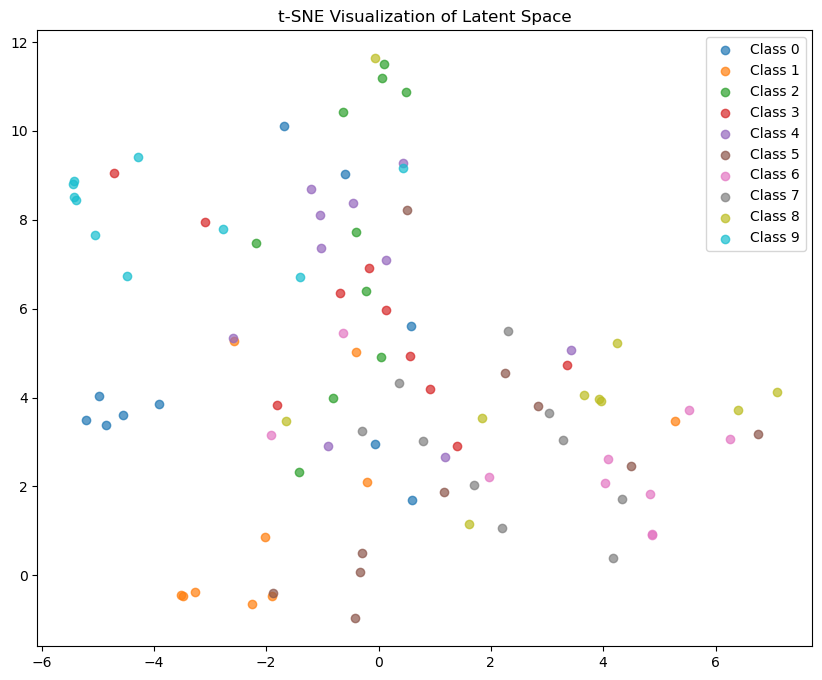

Silhouette Score: -0.0757, Davies-Bouldin Index: 2.9459


In [7]:
# Latent Feature 시각화
encoder.eval()
features_list, labels_list = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        latent_features = extract_latent_features(encoder, images).cpu().numpy()
        features_list.append(latent_features)
        labels_list.extend(labels.numpy())

features = np.concatenate(features_list, axis=0)
labels = np.array(labels_list)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for class_idx in np.unique(labels):
    idx = labels == class_idx
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {class_idx}', alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Latent Space")
plt.show()

silhouette = silhouette_score(features, labels)
dbi = davies_bouldin_score(features, labels)
print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")
